# Lecture 21: Image Processing with Neural Networks

In this session, we will delve into the implementation of Multilayer Perceptrons (MLPs), a class of feedforward artificial neural networks, using the CIFAR-10 dataset. We'll explore the architecture of MLPs, understand the importance of activation functions, and see how they perform with image data.


### Set up imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from skimage.color import rgb2gray
from skimage.filters import sobel

### Load images from CIFAR-10 Dataset

The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. [Learn more about CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# use this function to load the CIFAR-10 dataset from the data folder
def load_cifar_batch(filename):
    """Load a single batch of CIFAR-10."""
    with open(filename, 'rb') as file:
        # The encoding 'bytes' is required for Python 3 compatibility
        batch = pickle.load(file, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        # Reshape the images: the dataset is flattened, so you need to reshape it to 32x32x3
        images = images.reshape((len(images), 3, 32, 32)).transpose(0, 2, 3, 1)
        labels = np.array(labels)
        return images, labels

In [3]:
# load batch 1 of CIFAR-10
file_name = 'data/batch_1'

images, labels = load_cifar_batch(file_name)


### Inspect images and labels

Understanding the structure and format of our dataset is crucial. Let’s start by examining the lengths of images and labels to get a sense of the dataset's size.

In [4]:
# look at length of images and labels
print(len(images))
print(len(labels))

10000
10000


### Inspect the first three images

Visualizing our data is just as important as understanding its structure. Let’s display the first few images from our dataset along with their corresponding labels to see what we’re working with.


0


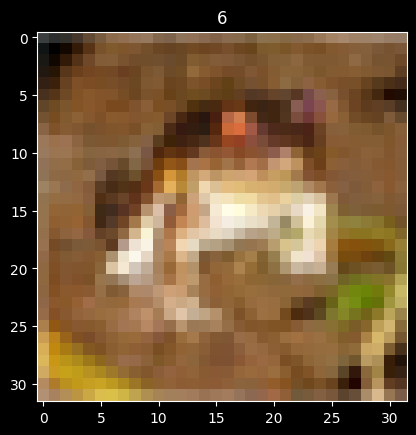

1


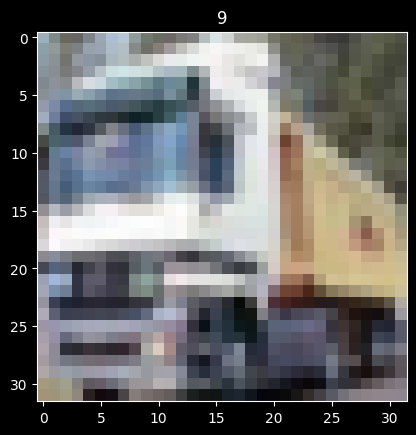

2


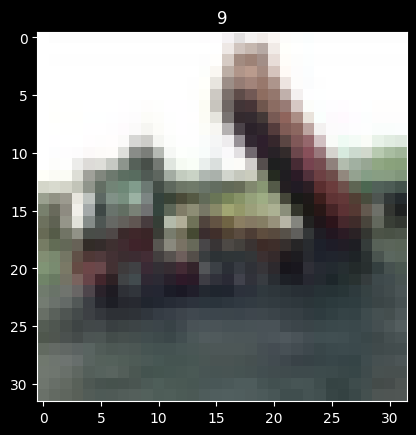

In [5]:
# Function to show an image
def show_image(img, label):
    plt.imshow(img)
    plt.title(label)
    plt.show()

# Show the first three images
for index in range(3):
    print(index)
    show_image(images[index], labels[index])

### Define labels
Each image in CIFAR-10 is associated with a label from 10 classes. Here, we define a list of label names to make our data more understandable.


In [6]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_names


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Inspect the first label

To further familiarize ourselves with the dataset, let's inspect the label of the first image. This step helps us connect an image with its categorical representation.


In [7]:
# inspect first label
first_label = labels[0]

label_names[first_label]

'frog'

In [8]:
# look at first image data
images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

### Preprocess data

Data preprocessing is a critical step in any machine learning workflow. Here, we'll normalize pixel values to improve our model's convergence during training. We'll also reshape the data to fit our model's input requirements.


In [9]:
# Normalize pixel values to be between 0 and 1
images_normalized = images / 255.0

images_normalized[0]


array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

In [10]:
# inspect the shape of the images
images_normalized.shape


(10000, 32, 32, 3)

In [11]:
# Flatten the images
images_flattened = images_normalized.reshape(images_normalized.shape[0], -1)

In [12]:
# inspect flattened images
images_flattened.shape

(10000, 3072)

In [13]:
32 * 32 * 3

3072

### Splitting Dataset into Training and Test Sets

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

In [15]:
# check that it worked
X_train.shape

(8000, 3072)

### Training a Machine Learning Model
This time use an MLPClassifier (Neural Network) with 2 hidden layers with 32 nodes each. Use the 'relu' activation function, and a maximum of 50 iterations.

In [16]:
# Initialize the model
model = MLPClassifier(
  hidden_layer_sizes=(32,32), 
  activation='relu', 
  max_iter=50, 
  random_state=42, 
  verbose=True
)

# Train the model
model.fit(X_train, y_train)

Iteration 1, loss = 2.23027332
Iteration 2, loss = 2.05612315
Iteration 3, loss = 1.97852523
Iteration 4, loss = 1.94073756
Iteration 5, loss = 1.91688954
Iteration 6, loss = 1.89673923
Iteration 7, loss = 1.87169636
Iteration 8, loss = 1.86962555
Iteration 9, loss = 1.85184109
Iteration 10, loss = 1.82727495
Iteration 11, loss = 1.83306652
Iteration 12, loss = 1.80850731
Iteration 13, loss = 1.79411427
Iteration 14, loss = 1.77849128
Iteration 15, loss = 1.77091432
Iteration 16, loss = 1.77025991
Iteration 17, loss = 1.76400551
Iteration 18, loss = 1.74096411
Iteration 19, loss = 1.74959025
Iteration 20, loss = 1.72429953
Iteration 21, loss = 1.72703170
Iteration 22, loss = 1.71354922
Iteration 23, loss = 1.70767577
Iteration 24, loss = 1.70371770
Iteration 25, loss = 1.69716467
Iteration 26, loss = 1.68592586
Iteration 27, loss = 1.67830860
Iteration 28, loss = 1.66959008
Iteration 29, loss = 1.66095574
Iteration 30, loss = 1.65867574
Iteration 31, loss = 1.66111495
Iteration 32, los

/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=50, random_state=42,
              verbose=True)

### Evaluating the Model
After training the model, evaluate its performance on the test set.

In [17]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Model accuracy: {accuracy:.2%}')


Model accuracy: 40.40%


### Make a dataframe with loss value for each iteration

In [18]:
# create loss_df with loss values for each iteration
loss_data = model.loss_curve_

loss_df = pd.DataFrame(loss_data, columns=['loss_1'])

loss_df


,loss_1
0,2.230273
1,2.056123
2,1.978525
3,1.940738
4,1.916890
5,1.896739
6,1.871696
7,1.869626
8,1.851841
9,1.827275


In [19]:
# add 150 zero values to the loss_df so that other interation lengths (i.e. 200) can be added
loss_data = model.loss_curve_ + [0] * 150

loss_df = pd.DataFrame(loss_data, columns=['loss_1'])

loss_df

,loss_1
0,2.230273
1,2.056123
2,1.978525
3,1.940738
4,1.916890
...,...
195,0.000000
196,0.000000
197,0.000000
198,0.000000


### Plot the loss curve

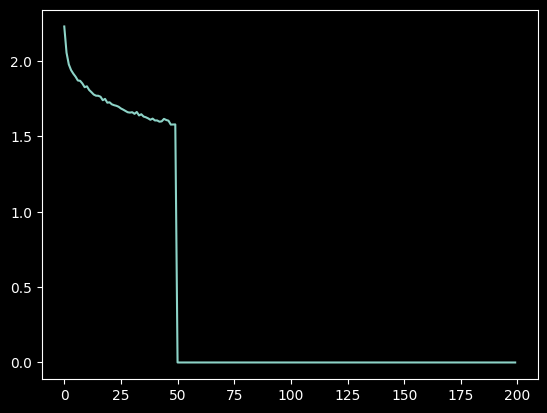

In [20]:
# plot the loss curve
plt.plot(loss_df)

### Experiment with different hyperparameters
First, expand the number of iterations to 200, and add loss values to the `loss_df`

In [21]:
# Initialize the model
model = MLPClassifier(
  hidden_layer_sizes=(32,32), 
  activation='relu', 
  max_iter=200, 
  random_state=42, 
  verbose=True
)

# Train the model
model.fit(X_train, y_train)

Iteration 1, loss = 2.23027332
Iteration 2, loss = 2.05612315
Iteration 3, loss = 1.97852523
Iteration 4, loss = 1.94073756
Iteration 5, loss = 1.91688954
Iteration 6, loss = 1.89673923
Iteration 7, loss = 1.87169636
Iteration 8, loss = 1.86962555
Iteration 9, loss = 1.85184109
Iteration 10, loss = 1.82727495
Iteration 11, loss = 1.83306652
Iteration 12, loss = 1.80850731
Iteration 13, loss = 1.79411427
Iteration 14, loss = 1.77849128
Iteration 15, loss = 1.77091432
Iteration 16, loss = 1.77025991
Iteration 17, loss = 1.76400551
Iteration 18, loss = 1.74096411
Iteration 19, loss = 1.74959025
Iteration 20, loss = 1.72429953
Iteration 21, loss = 1.72703170
Iteration 22, loss = 1.71354922
Iteration 23, loss = 1.70767577
Iteration 24, loss = 1.70371770
Iteration 25, loss = 1.69716467
Iteration 26, loss = 1.68592586
Iteration 27, loss = 1.67830860
Iteration 28, loss = 1.66959008
Iteration 29, loss = 1.66095574
Iteration 30, loss = 1.65867574
Iteration 31, loss = 1.66111495
Iteration 32, los

/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(32, 32), random_state=42, verbose=True)

In [22]:
# add a new column to the loss_df with the new loss values and plot the updated loss curves
loss_df['loss_2'] = model.loss_curve_

loss_df

,loss_1,loss_2
0,2.230273,2.230273
1,2.056123,2.056123
2,1.978525,1.978525
3,1.940738,1.940738
4,1.916890,1.916890
...,...,...
195,0.000000,1.309851
196,0.000000,1.310665
197,0.000000,1.306761
198,0.000000,1.299499


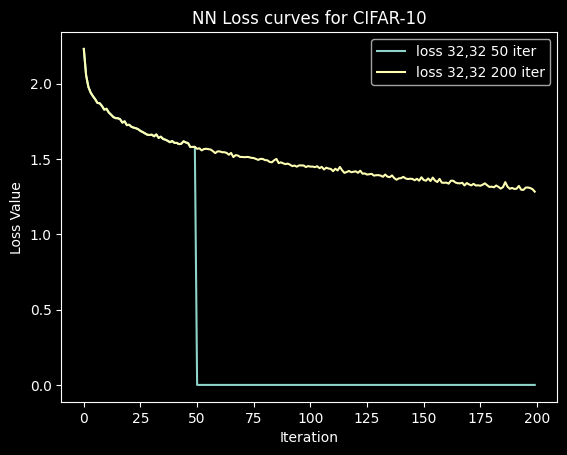

In [23]:
plt.plot(loss_df)
plt.title('NN Loss curves for CIFAR-10')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend(['loss 32,32 50 iter', 'loss 32,32 200 iter'])

### Activity: Hyperparameter Tuning a Neural Network

In this activity, we will perform hyperparameter tuning for our [Multilayer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) model. Using `GridSearchCV`, we will search for the best combination of hyperparameters, including activation function, hidden layer sizes, learning rate, and the number of iterations.

### Train models with different hidden layer sizes
Using 200 iteration, train NN's with hidden layers of (64, 64) and (128, 128)

In [24]:
# Initialize the model with new (64 by 64) hidden layer sizes and 200 iterations (max_iter=200)
model = MLPClassifier(
  hidden_layer_sizes=(64,64), 
  activation='relu', 
  max_iter=200, 
  random_state=42, 
  verbose=True
)

# Train the model
model.fit(X_train, y_train)

# create loss_3 column in loss_df and plot the updated loss curves
loss_df['loss_3'] = model.loss_curve_


Iteration 1, loss = 2.19871723
Iteration 2, loss = 1.98703820
Iteration 3, loss = 1.92009833
Iteration 4, loss = 1.87712496
Iteration 5, loss = 1.83656475
Iteration 6, loss = 1.80676771
Iteration 7, loss = 1.78261436
Iteration 8, loss = 1.74485112
Iteration 9, loss = 1.72721273
Iteration 10, loss = 1.71340971
Iteration 11, loss = 1.68927434
Iteration 12, loss = 1.66526506
Iteration 13, loss = 1.66084539
Iteration 14, loss = 1.64637989
Iteration 15, loss = 1.62572482
Iteration 16, loss = 1.61884077
Iteration 17, loss = 1.59833722
Iteration 18, loss = 1.58928736
Iteration 19, loss = 1.57650389
Iteration 20, loss = 1.56650877
Iteration 21, loss = 1.55499656
Iteration 22, loss = 1.55635193
Iteration 23, loss = 1.54476511
Iteration 24, loss = 1.53075195
Iteration 25, loss = 1.54017294
Iteration 26, loss = 1.50940915
Iteration 27, loss = 1.50544477
Iteration 28, loss = 1.51171975
Iteration 29, loss = 1.48876109
Iteration 30, loss = 1.48468789
Iteration 31, loss = 1.48531076
Iteration 32, los

/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# Initialize the model with new (128 by 128) hidden layer sizes and 200 iterations (max_iter=200), train it, and add to loss_df
model = MLPClassifier(
  hidden_layer_sizes=(128,128), 
  activation='relu', 
  max_iter=200, 
  random_state=42, 
  verbose=True
)

# Train the model
model.fit(X_train, y_train)

# create loss_4 column in loss_df and plot the updated loss curves
loss_df['loss_4'] = model.loss_curve_

Iteration 1, loss = 2.20508564
Iteration 2, loss = 1.98057271
Iteration 3, loss = 1.91076244
Iteration 4, loss = 1.83391894
Iteration 5, loss = 1.79106199
Iteration 6, loss = 1.77386545
Iteration 7, loss = 1.73783244
Iteration 8, loss = 1.71054378
Iteration 9, loss = 1.69927783
Iteration 10, loss = 1.67452517
Iteration 11, loss = 1.66001451
Iteration 12, loss = 1.62827029
Iteration 13, loss = 1.60818434
Iteration 14, loss = 1.59509287
Iteration 15, loss = 1.57029914
Iteration 16, loss = 1.54793662
Iteration 17, loss = 1.53138002
Iteration 18, loss = 1.53101783
Iteration 19, loss = 1.49097880
Iteration 20, loss = 1.48199154
Iteration 21, loss = 1.46424709
Iteration 22, loss = 1.45052105
Iteration 23, loss = 1.43551866
Iteration 24, loss = 1.41462919
Iteration 25, loss = 1.41191497
Iteration 26, loss = 1.39318402
Iteration 27, loss = 1.39608372
Iteration 28, loss = 1.38368903
Iteration 29, loss = 1.39511509
Iteration 30, loss = 1.36048911
Iteration 31, loss = 1.32967827
Iteration 32, los

/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


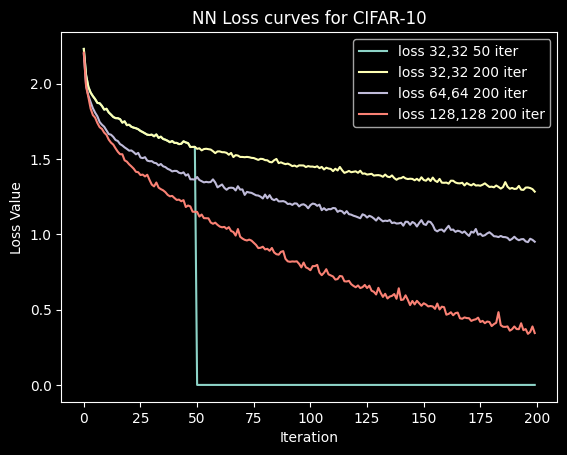

In [26]:
# plot the updated loss curves
plt.plot(loss_df)
plt.title('NN Loss curves for CIFAR-10')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend(['loss 32,32 50 iter', 'loss 32,32 200 iter', 'loss 64,64 200 iter', 'loss 128,128 200 iter'])

### Run a grid search with the following hyperparameters:
hidden_layer_sizes: (128, 128)

activation: tanh or relu

learning_rate: constant or adaptive

max_iter: 100

Use three fold cross validation.

In [28]:
# import the GridSearchCV
from sklearn.model_selection import GridSearchCV

# define params for the GridSearchCV
params = {
  'hidden_layer_sizes': [(128,128)],
  'activation': ['tanh', 'relu'],
  'learning_rate': ['constant', 'adaptive'],
}



# Initialize the model, and run grid search
model = MLPClassifier(max_iter=200, random_state=42)
grid_search = GridSearchCV(model, params, verbose=10, n_jobs=-1)

# Train the model
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5; 2/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive[CV 1/5; 1/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant

[CV 2/5; 1/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant
[CV 5/5; 2/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive
[CV 5/5; 1/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant
[CV 4/5; 2/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive
[CV 2/5; 2/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive
[CV 3/5; 1/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant[CV 1/5; 3/4] START activation=relu, hidden_layer_sizes=(128, 128), learning_rate=constant

[CV 4/5; 1/4] START activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant
[CV 1/5; 2/4] START activation

/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 3/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.383 total time=10.4min
[CV 1/5; 3/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.384 total time=10.4min
[CV 2/5; 4/4] START activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive
[CV 3/5; 4/4] START activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 1/4] END activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.390 total time=11.6min
[CV 2/5; 1/4] END activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.375 total time=11.6min
[CV 4/5; 2/4] END activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.390 total time=11.6min
[CV 4/5; 4/4] START activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive
[CV 5/5; 4/4] START activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 2/4] END activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.375 total time=11.6min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 2/4] END activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.364 total time=11.6min
[CV 5/5; 1/4] END activation=tanh, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.364 total time=11.6min
[CV 3/5; 3/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.379 total time= 7.6min
[CV 3/5; 4/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.379 total time= 7.5min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 3/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.400 total time= 7.9min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 3/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=constant;, score=0.386 total time= 7.8min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 4/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.384 total time= 7.8min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 4/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.383 total time= 7.8min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 4/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.386 total time= 6.8min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 4/4] END activation=relu, hidden_layer_sizes=(128, 128), learning_rate=adaptive;, score=0.400 total time= 6.8min


/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(128, 128)],
                         'learning_rate': ['constant', 'adaptive']},
             verbose=10)

### Print the best hyperparamers

In [29]:
# print the best parameters
grid_search.best_params_


{'activation': 'relu',
 'hidden_layer_sizes': (128, 128),
 'learning_rate': 'constant'}

### Train a model with the best hyperparameters, add loss data to dataframe, and plot

In [30]:
# Initialize the model with new (128 by 128) hidden layer sizes and 200 iterations (max_iter=200), train it, and add to loss_df
model = MLPClassifier(
  hidden_layer_sizes=(128,128), 
  activation='relu', 
  max_iter=200, 
  random_state=42, 
  learning_rate='constant',
  verbose=True
)

# Train the model
model.fit(X_train, y_train)

# create loss_4 column in loss_df and plot the updated loss curves
loss_df['loss_5'] = model.loss_curve_

Iteration 1, loss = 2.20508564
Iteration 2, loss = 1.98057271
Iteration 3, loss = 1.91076244
Iteration 4, loss = 1.83391894
Iteration 5, loss = 1.79106199
Iteration 6, loss = 1.77386545
Iteration 7, loss = 1.73783244
Iteration 8, loss = 1.71054378
Iteration 9, loss = 1.69927783
Iteration 10, loss = 1.67452517
Iteration 11, loss = 1.66001451
Iteration 12, loss = 1.62827029
Iteration 13, loss = 1.60818434
Iteration 14, loss = 1.59509287
Iteration 15, loss = 1.57029914
Iteration 16, loss = 1.54793662
Iteration 17, loss = 1.53138002
Iteration 18, loss = 1.53101783
Iteration 19, loss = 1.49097880
Iteration 20, loss = 1.48199154
Iteration 21, loss = 1.46424709
Iteration 22, loss = 1.45052105
Iteration 23, loss = 1.43551866
Iteration 24, loss = 1.41462919
Iteration 25, loss = 1.41191497
Iteration 26, loss = 1.39318402
Iteration 27, loss = 1.39608372
Iteration 28, loss = 1.38368903
Iteration 29, loss = 1.39511509
Iteration 30, loss = 1.36048911
Iteration 31, loss = 1.32967827
Iteration 32, los

/Users/garrettroell/be491/BE-491-Lecture-21/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


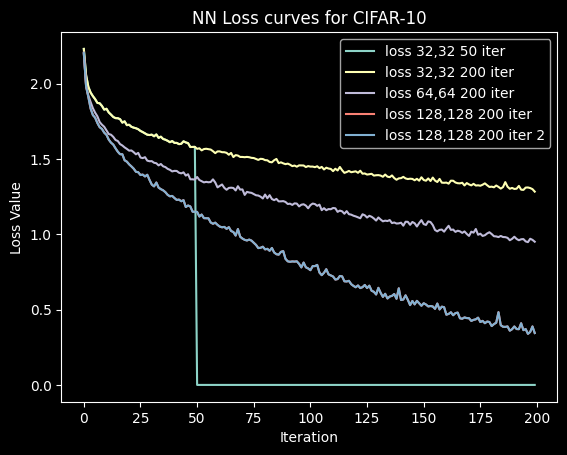

In [31]:
# plot the updated loss curves
plt.plot(loss_df)
plt.title('NN Loss curves for CIFAR-10')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.legend(['loss 32,32 50 iter', 'loss 32,32 200 iter', 'loss 64,64 200 iter', 'loss 128,128 200 iter', 'loss 128,128 200 iter 2'])

### Print the accuracy of the model on the test data

In [32]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Model accuracy: {accuracy:.2%}')

Model accuracy: 42.35%


### End of Activity